In [1]:
import pandas as pd
import json
import numpy as np
import requests
import urllib
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import textdistance
import string
import re
from dateutil import parser
import time
from googletrans import Translator

In [2]:
with open('data/final/sampled_references_es.json','r',encoding='utf-8') as f:
    json_es = json.load(f)
    df = pd.DataFrame(json_es)
df['verified'] = False
df.shape

(340, 10)

In [3]:
def norm_string(s):
    #return s.lower().translate(str.maketrans('', '', string.punctuation))
    return re.sub('\W+','', s).lower()

def compare(s1,s2):
    return textdistance.levenshtein.normalized_similarity(norm_string(s1),norm_string(s2))

## We check the netlocs to see what checks can be automatized

In [4]:
urlparse_df = df['url'].transform(urlparse)
urlparse_df = pd.DataFrame(urlparse_df.tolist(), index=urlparse_df.index)
df[['scheme','netloc','path','params','query','fragment']] = urlparse_df
pd.DataFrame(df['netloc'].value_counts()).reset_index().head(10)

,index,netloc
0,es.wikipedia.org,113
1,www.ebi.ac.uk,56
2,tools.wmflabs.org,33
3,viaf.org,27
4,datos.bne.es,19
5,www.museodelprado.es,14
6,www.congreso.es,7
7,dbe.rah.es,4
8,www.boe.es,4
9,www.filmaffinity.com,4


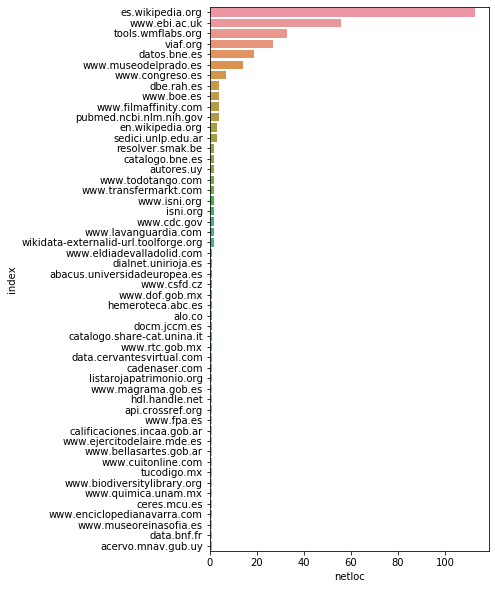

In [5]:
fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.barplot(data = pd.DataFrame(df['netloc'].value_counts()).reset_index(),
           y = 'index',x='netloc', ax=ax)
plt.show()

## www.ebi.ac.uk
We see here that there are many types of predicates, but automating these many checks may be done.

Some here have the path for the api, some do not. We can only check those directed at the API, so we filter them. The ones filtered out are protein and gene databases which we'll check later.

### Article API

In [6]:
df_ebi = df[df['netloc'] == 'www.ebi.ac.uk']
df_ebi_api = df_ebi[df_ebi['path'] == '/europepmc/webservices/rest/search']
df_ebi_api['predicate'].value_counts(), df_ebi_api.shape[0]

(nombre del autor        17
 publicado en             6
 tomo                     6
 identificador PubMed     5
 fecha de publicación     4
 número de ejemplar       4
 DOI                      4
 instancia de             4
 página                   3
 autor                    2
 título                   1
 Name: predicate, dtype: int64,
 56)

In [7]:
def verify_ebi_api(row, verbose=True):
#for i, row in df_en_ebi_api.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    d = requests.get(row['url']).json()['resultList']['result']
    
    if compare(subject, d[0]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d[0]['title'])
        #break
        return found
    if predicate == 'instancia de':
        value = d[0]['pubTypeList']['pubType']
        if obj == 'artículo científico' and 'Journal Article' in value or 'Case Reports' in value:
            found = True            
    elif predicate == 'fecha de publicación':
        value = d[0]['firstPublicationDate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
    elif predicate == 'publicado en':
        obj = obj.replace('The BMJ','British medical journal')
        value = d[0]['journalInfo']['journal']['title']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = d[0]['doi']
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'nombre del autor' or predicate == 'autor':
        value = d[0]['authorList']['author']
        for author in value:
            #if 'fullName' in author:
            #    print('Full name:',author['fullName'])
            #if 'firstName' in author:
            #    print('First and last names:',author['firstName'] + ' ' + author['lastName'])
            #print(obj)
            if 'fullName' in author and compare(obj, author['fullName']) >= 0.99:
                found = True
            elif 'firstName' in author and compare(obj, author['firstName'] + ' ' + author['lastName']) >= 0.99:
                found = True
    elif predicate == 'tomo':
        value = d[0]['journalInfo']['volume']
        if value == obj:
            found = True
    elif predicate == 'página':
        value = d[0]['pageInfo']
        if value == obj:
            found = True
    elif predicate == 'número de ejemplar':
        value = d[0]['journalInfo']['issue']
        if value == obj:
            found = True
    elif predicate == 'identificador PubMed':
        value = d[0]['id']
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'título':
        value = d[0]['title']
        if compare(obj, d[0]['title']) >= 0.9:
            found = True
    elif predicate == 'PMCID':
        value = d[0]['pmcid']
        if ('PMC'+obj) == value:
            found = True
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_ebi_api_verified = df_ebi_api.apply(verify_ebi_api,axis=1)
print('{}% are confirmed'.format(100*df_ebi_api_verified.sum()/len(df_ebi_api_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_ebi_api.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_ebi_api[df_ebi_api_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


### The rest of ebi.ac.uk (genes and proteins)

Conclusion: Names in subject / object differ too much from those obtained in the APIs, and there seems to be great need of domain knowledge (biology) to navigate through the information, making automatically checking the API daunting and approaches manual effort.

# pubmed.ncbi.nlm.nih.gov

These use a very similar json structure to ebi.ac.uk and the same endpoint as eutils so it is also possible to automatize

In [8]:
df_pubmed = df[df['netloc'] == 'pubmed.ncbi.nlm.nih.gov']
df_pubmed['predicate'].value_counts(), df_pubmed.shape

(nombre del autor        1
 fecha de publicación    1
 publicado en            1
 instancia de            1
 Name: predicate, dtype: int64,
 (4, 16))

In [9]:
def verify_pubmed(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    pubmed_id = row['url'].split('/')[-1]
    while 1:
        url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={}&retmode=json'.format(pubmed_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    if compare(subject, d['result'][pubmed_id]['title']) < 0.9:
        if verbose:
            print(subject)
            print(d['result'][pubmed_id]['title'])
        #break
        return found
        
    if predicate == 'instancia de':
        value = d['result'][pubmed_id]['pubtype']
        if obj == 'artículo científico' and 'Journal Article' in value:
            found = True            
    elif predicate == 'fecha de publicación':
        value = d['result'][pubmed_id]['sortpubdate']
        if parser.parse(obj).date() == parser.parse(value).date():
            found = True
        if 'epubdate' in d['result'][pubmed_id]:
            value = d['result'][pubmed_id]['epubdate']
            if parser.parse(obj).date() == parser.parse(value).date():
                found = True
    elif predicate == 'publicado en':
        value = d['result'][pubmed_id]['fulljournalname']
        value = value.split(' = ')
        for v in value:
            if compare(obj, v) >= 0.6:
                found = True
    elif predicate == 'DOI':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'doi'][0]
        if compare(obj, value) >= 0.99:
            found = True
    elif predicate == 'nombre del autor' or predicate == 'autor':
        value = d['result'][pubmed_id]['authors']
        for author in value:
            if compare(obj, author['name']) >= 0.99:
                found = True
            else:
                authornames = re.split(' ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = ' '.join(authornames[1:]) + ' ' + authornames[0][1]
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                    
                authornames = re.split('-| ',obj)
                name_reordered = authornames[-1] + ' ' + ''.join(authornames[:-1])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
                name_reordered = authornames[-1] + ' ' + ''.join([n[0] for n in authornames[:-1]])
                if compare(name_reordered, author['name']) >= 0.80:
                    found = True
    elif predicate == 'tomo':
        value = d['result'][pubmed_id]['volume']
        if value == obj:
            found = True
    elif predicate == 'página':
        value = d['result'][pubmed_id]['pages']
        values = value.split('-')
        if len(values[1]) < len(values[0]):
            valuedif = len(values[0]) - len(values[1])
            value = values[0] + '-' + values[0][0:valuedif] + values[1]
        if value == obj:
            found = True
    elif predicate == 'número de ejemplar':
        value = d['result'][pubmed_id]['issue']
        if value == obj:
            found = True
    elif predicate == 'identificador PubMed':
        value = [v['value'] for v in d['result'][pubmed_id]['articleids'] if v['idtype'] == 'pubmed'][0]
        if value == obj:
            found = True
    #elif predicate == 'author':
    #    value = d[0]['authorList']['author']
    elif predicate == 'título':
        value = d['result'][pubmed_id]['title']
        if compare(obj, value) >= 0.9:
            found = True
    #elif predicate == 'PMCID':
    #    value = d[0]['pmcid']
    #    if ('PMC'+obj) == value:
    #        found = True
    if not found and verbose:
        print(url)
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_pubmed_verified = df_pubmed.apply(verify_pubmed,axis=1)
print('{}% are confirmed'.format(100*df_pubmed_verified.sum()/len(df_pubmed_verified)))


# Mark them in the original df so that we don't crowdsource them
for i in df_pubmed.index:
    df.loc[i,'verified'] = True
    
# Those not verified
df_pubmed[df_pubmed_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


## api.crossref.org

simple api and not many predicates, automatable

In [10]:
df_crossref = df[df['netloc'] == 'api.crossref.org']
df_crossref['predicate'].value_counts()

referencia    1
Name: predicate, dtype: int64

In [11]:
import urllib.parse
cont_info = '?mailto=k2031554@kcl.ac.uk'

def verify_crossref(row, verbose=True):
#verbose = True
#for i, row in df_en_crossref.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    d = requests.get(row['url']+cont_info).json()
    
    if compare(subject, d['message']['title'][0]) < 0.9:
        translator = Translator()
        translated_title = translator.translate(d['message']['title'][0], dest='en').text
        if compare(subject, translated_title) <0.7:
            if verbose:
                print(subject)
                print(d['message']['title'][0])
                print(translated_title)
        #break
            return found
        
    if predicate == 'instancia de':
        value = d['message']['type']
        if obj == 'scholarly article' and 'journal-article' in value:
            found = True 
    elif predicate == 'referencia':
        if 'reference' in d['message']:
            value = d['message']['reference']
        else:
            value = []
        for ref in value:
            try:
                if 'DOI' in ref:
                    doi = urllib.parse.quote_plus(ref['DOI'])
                    resp = requests.get('https://api.crossref.org/works/'+doi+cont_info)
                    if resp.status_code != 404:
                        if len(resp.json()['message']['title']) > 0:
                            title = resp.json()['message']['title'][0]
                        elif len(resp.json()['message']['container-title']) >0:
                            title = resp.json()['message']['container-title'][0]
                        else:
                            title = ''
                    else:
                        title = ''
                    #print(title)
                elif 'unstructured' in ref:
                    title = ref['unstructured'].split('In:')[0]
                    #print(title)
                elif 'volume-title' in ref:
                    title = ref['volume-title']
                elif 'article-title' in ref:
                    title = ref['article-title']
                if compare(obj,title) >= 0.9:
                    found = True
                    break
                else:
                    translator = Translator()
                    translated_title = translator.translate(title, dest='en').text
                    if compare(obj, translated_title) >= 0.7:
                        found = True
                        break
            except Exception as e:
                print(row['url'])
                print(e)
                print(doi)
                print(resp.__dict__)
                print('\n')
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_crossref_verified = df_crossref.apply(verify_crossref,axis=1)
print('{}% are confirmed'.format(100*df_crossref_verified.sum()/len(df_crossref_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_crossref.index:
    df.loc[i,'verified'] = True

# Those not verified
df_crossref[df_crossref_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


## viaf.org



In [12]:
df_viaf = df[df['netloc'] == 'viaf.org']
df_viaf['predicate'].value_counts()

ID WorldCat de identidades    18
identificador NKC              2
identificador NTA              2
identificador GND              1
ID ref SUDOC                   1
identificador BnF              1
identificador PTBNP            1
identificador BAV              1
Name: predicate, dtype: int64

In [13]:
def verify_viaf(row, verbose=True):
#verbose = True
#for i, row in df_en_pubmed.iterrows():
    found = False
    subject = row['subject']
    obj = row['object']
    predicate = row['predicate']
    
    viaf_id = row['url'].split('/')[-1]
    
    while 1:
        url = 'http://www.viaf.org/viaf/{}/viaf.json'.format(viaf_id)
        resp = requests.get(url)
        if resp.status_code == 502:
            continue
        else:
            break
    try:
        d = resp.json()
    except Exception:
        print(url)
        print(resp)
        return False
    
    names = [name['text'] for name in d['mainHeadings']['data']]
    for to_add in ['mainHeadings/mainHeadingEl','x400s/x400','x500s/x500']:
        to_add = to_add.split('/')
        if to_add[0] in d:
            if type(d[to_add[0]][to_add[1]]) != list:
                d[to_add[0]][to_add[1]] = [d[to_add[0]][to_add[1]]]
            names_i = [i['datafield']['subfield'] for i in d[to_add[0]][to_add[1]]]
            names_i = [n if type(n) == list else [n] for n in names_i]
            names_i = [item['#text'] for sublist in names_i for item in sublist]
            names += names_i

    if all([compare(subject,name) < 0.9 for name in names]):
        if verbose:
            print(url)
            print(subject)
            print(names)
        #break
        return found
    
    non_flat_ids = [[s] if type(s) != list else s for s in [s['sources']['sid'] for s in d['mainHeadings']['data']]]
    flat_ids = [item for sublist in non_flat_ids for item in sublist]
    if 'xLinks' in d:
        xLinks = [i if type(i) == str else i['#text'] for i in d['xLinks']['xLink']] if type(d['xLinks']['xLink']) == list else d['xLinks']['xLink']
        if type(xLinks) != list:
            xLinks = [xLinks]
            
    if predicate == 'identificador BnF':
        value = [i for i in flat_ids if i.startswith('BNF|')][0].split('|')[-1]
        if obj in [value, value+'r',value+'t']:
            found = True
    elif predicate == 'ID WorldCat de identidades':
        value = [i for i in xLinks if i.startswith('https://www.worldcat.org/identities/')][0].split('/')[-1]
        if obj == value:
            found = True
    elif predicate == 'identificador BAV':
        value = [i for i in flat_ids if i.startswith('BAV|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador NTA':
        value = [i for i in flat_ids if i.startswith('NTA|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador NKC':
        value = [i for i in flat_ids if i.startswith('NKC|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'ID ref SUDOC':
        value = [i for i in flat_ids if i.startswith('SUDOC|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador GND':
        value = [i for i in flat_ids if i.startswith('DNB|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    elif predicate == 'identificador PTBNP':
        value = [i for i in flat_ids if i.startswith('PTBNP|')][0].split('|')[-1]
        if obj in [value]:
            found = True
    else:
        print(flat_ids)
    
    
    if not found and verbose:
        print(predicate)
        print(obj)
        print(value)
        #break
    return found

df_viaf_verified = df_viaf.apply(verify_viaf,axis=1)
print('{}% are confirmed'.format(100*df_viaf_verified.sum()/len(df_viaf_verified)))

# Mark them in the original df so that we don't crowdsource them
for i in df_viaf.index:
    df.loc[i,'verified'] = True

# Those not verified
df_viaf[df_viaf_verified == False]

100.0% are confirmed


,reference_id,url,ref_node_pairs,language_crawl,statement_node,subject,predicate,object,g_id,verified,scheme,netloc,path,params,query,fragment


## tools.wmflabs.org

The info that comes with the API does not always have all the info asked in the predicates, but has sometimes links/coordinates/loose structure that helps you figure it out. For example, Castillo Medieval as titled in Wikidata is in the URl Castillo Medieval (Monturque), and these parenthesis make a distinction between this and other Medieval Castles. It also states in wikidata that it is a biene de interes cultural, but in the URL the only hint at this is that the source url is at http://es.wikipedia.org/w/index.php?title=Anexo:Bienes_de_interés_cultural_de_la_provincia_de_Córdoba&oldid=126223650. So this all requires a human eye.

## datos.bne.es
I could not find an API for this.

# Final: filter reference list for tasks and create file with checked references

In [14]:
df[df['verified'] == False]['netloc'].value_counts()

es.wikipedia.org                         113
tools.wmflabs.org                         33
datos.bne.es                              19
www.museodelprado.es                      14
www.congreso.es                            7
www.boe.es                                 4
www.filmaffinity.com                       4
dbe.rah.es                                 4
en.wikipedia.org                           3
sedici.unlp.edu.ar                         3
www.lavanguardia.com                       2
isni.org                                   2
www.todotango.com                          2
www.cdc.gov                                2
wikidata-externalid-url.toolforge.org      2
www.isni.org                               2
www.transfermarkt.com                      2
autores.uy                                 2
resolver.smak.be                           2
catalogo.bne.es                            2
www.ejercitodelaire.mde.es                 1
alo.co                                     1
www.biodiv

In [15]:
not_verified_reference_ids = list(df[df['verified'] == False]['reference_id'])
print('Number of non-verified references: {}. That is {}% left from the total.'.format(
    len(not_verified_reference_ids), 100*len(not_verified_reference_ids)/df.shape[0]
))
not_verified_references = [j for j in json_es if j['reference_id'] in not_verified_reference_ids]
with open('data/final/filtered_sampled_references_es_rel.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references,f ,indent=2,ensure_ascii=False)

Number of non-verified references: 252. That is 74.11764705882354% left from the total.


In [ ]:
def is_wikipedia(url):
    if url.startswith('https://es.wikipedia.org'):
        return True
    elif url.startswith('https://en.wikipedia.org'):
        return True
    return False

not_verified_references_non_wikipedia = [r for r in not_verified_references if not is_wikipedia(r['url'])]
with open('data/final/non_gd_filtered_sampled_references/filtered_sampled_references_es_auth.json','w',encoding='utf-8') as f:
    json.dump(not_verified_references_non_wikipedia,f ,indent=2,ensure_ascii=False)

In [16]:
df[df['verified'] == True]['netloc'].value_counts()

www.ebi.ac.uk              56
viaf.org                   27
pubmed.ncbi.nlm.nih.gov     4
api.crossref.org            1
Name: netloc, dtype: int64

In [17]:
verified_reference_ids = list(df[df['verified'] == True]['reference_id'])
print('Number of verified references: {}. That is {}% from the total.'.format(
    len(verified_reference_ids), 100*len(verified_reference_ids)/df.shape[0]
))

Number of verified references: 88. That is 25.88235294117647% from the total.


In [20]:
verified_references = [j for j in json_es if j['reference_id'] in verified_reference_ids]
for vr in verified_references:
    vr['g_id'] = {
      "relevance": {
          "is_present": 1,
          "difficulty": -1,
          "reason": -1
      },
      "authorit":{
          "author": -1,
          "publisher": -1,
          "sub_publisher": -1
      }
    }
    
    if 'www.ebi.ac.uk/europepmc/webservices/rest/search' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'pubmed.ncbi.nlm.nih.gov' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 3
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 0
    elif 'api.crossref.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 1
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 0
        vr['g_id']['authorit']['sub_publisher'] = 2
    elif 'viaf.org' in vr['url']:
        vr['g_id']['relevance']['difficulty'] = 2
        vr['g_id']['authorit']['author'] = 1
        vr['g_id']['authorit']['publisher'] = 1
        vr['g_id']['authorit']['sub_publisher'] = 3        

with open('data/final/non_gd_annotations_auto_api/autochecked_sampled_references_es.json','w',encoding='utf-8') as f:
    json.dump(verified_references,f ,indent=2,ensure_ascii=False)

### Then, go to the autochecked results file saved on the previous cell and edit the cases where verification failed